<a href="https://colab.research.google.com/github/shufan6011/ML-Projects/blob/main/Step_5_RNNs_for_GW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Update:
# Use GPU instead of CPU for model training

# Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import requests, os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split


In [ ]:
# Go to https://gwosc.org
# Find the information required below (GPS time & detector)


In [ ]:
# Set a GPS time:
t_start = 1126259462.4
t_end = 1126259462.4 # For specific events, make t_end the same as t_start

# Choose detector as H1, L1, or V1
detector = 'H1'


In [ ]:
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy==3.0.8"
    ! pip install -q "matplotlib==3.9.0"
    ! pip install -q "astropy==6.1.0"
    from gwpy.timeseries import TimeSeries


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.5 MB/s eta 0:00:00


In [ ]:
from gwosc.locate import get_urls
url = get_urls(detector, t_start, t_end)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:
    straindata = requests.get(url)
    strainfile.write(straindata.content)


Downloading:  http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [ ]:
# Read strain data
strain = TimeSeries.read(fn,format='hdf5.gwosc')

# Examine an interval of the event closely
# center = int(t_start)
# strain = strain.crop(center-0.2, center+0.1)

# Extract timestamps and strain values
timestamps = strain.times.value
strain_values = strain.value

# Store the data in a Pandas DataFrame
data = pd.DataFrame({
    'time': timestamps,
    'strain': strain_values
})


## Handling Missing Values

In [ ]:
# Drop rows with missing values
data = data.dropna()

print("\nMissing values after cleaning:")
print(data.isnull().sum())



Missing values after cleaning:
time      0
strain    0
dtype: int64


## Data Noise Filtering

In [ ]:
# Band-pass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    try:
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    try:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data)
        return y
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Filter parameters
lowcut = 20  # Low cutoff frequency (Hz)
highcut = 500  # High cutoff frequency (Hz)

# Apply band-pass filter to the strain data
data['strain'] = bandpass_filter(data['strain'], lowcut, highcut, 4096)


## Data Normalization

In [ ]:
# Normalize the filtered strain data
scaler = StandardScaler()
data['strain'] = scaler.fit_transform(data[['strain']])


## Data Inspection

In [ ]:
# Inspect the first few rows
print("First few rows of the data:")
print(data.head())

# Inspect col headers
print("\nCol headers:")
print(data.columns)

# Summary stats
print("\nSummary stats:")
print(data.describe())

# Check for missing vals
print("\nMissing vals in each col:")
print(data.isnull().sum())

# Check the sampling frequency
print(f"Sampling frequency: {strain.sample_rate} Hz")
fs = 4096 # Change this if sampling frequency is different

# Convert the preprocessed data back to original strain
scaler.inverse_transform(data)


First few rows of the data:
           time    strain
0  1.126257e+09 -2.509170
1  1.126257e+09  0.070279
2  1.126257e+09  2.209691
3  1.126257e+09  3.618610
4  1.126257e+09  4.256309

Col headers:
Index(['time', 'strain'], dtype='object')

Summary stats:
               time        strain
count  1.677722e+07  1.677722e+07
mean   1.126259e+09 -1.758737e-17
std    1.182413e+03  1.000000e+00
min    1.126257e+09 -3.686864e+00
25%    1.126258e+09 -7.088868e-01
50%    1.126259e+09  1.167451e-03
75%    1.126260e+09  7.087773e-01
max    1.126262e+09  4.284804e+00

Missing vals in each col:
time      0
strain    0
dtype: int64
Sampling frequency: 4096.0 Hz Hz


array([[ 1.75504148e-12, -3.91002974e-21],
       [ 1.75504148e-12,  1.09512775e-22],
       [ 1.75504148e-12,  3.44334855e-21],
       ...,
       [ 1.75504786e-12, -3.63177486e-21],
       [ 1.75504786e-12, -2.07874005e-21],
       [ 1.75504786e-12,  3.14511820e-23]])

## Data Augmentation

In [ ]:
def augment_data(data, labels):
    try:
        augmented_data = []
        augmented_labels = []
        for d, l in zip(data, labels):
            augmented_data.append(d)
            augmented_labels.append(l)
            augmented_data.append(np.flip(d, axis=0))
            augmented_labels.append(l)
            noise = np.random.normal(0, 0.1, d.shape)
            augmented_data.append(d + noise)
            augmented_labels.append(l)
        return np.array(augmented_data), np.array(augmented_labels)
    except Exception as e:
        print(f"An error occurred: {e}")
        return []


## Data Segmenting & Labeling

In [ ]:
def create_segments_and_labels(strain, event_time, window_size, sample_rate):
    try:
        # Resample strain to desired sample rate (if necessary)
        strain = strain.resample(sample_rate)

        # Initialize segments and labels lists
        segments = []
        labels = []

        # Calculate the number of samples per segment
        segment_length = int(window_size * sample_rate)

        # Create segments and labels
        for i in range(0, len(strain) - segment_length, segment_length):
            segment = strain[i:i + segment_length]
            segments.append(segment.value)

            # Label based on event presence
            if segment.times.value[0] <= event_time <= segment.times.value[-1]:
                labels.append(1)  # Event present
            else:
                labels.append(0)  # No event

        # Convert to numpy arrays
        segments = np.array(segments)
        labels = np.array(labels)

        print(f"Segments shape: {segments.shape}")
        print(f"Labels shape: {labels.shape}")

        # Verify segments and labels
        print("First few segments:")
        print(segments[:2])

        return segments, labels
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

segments, labels = create_segments_and_labels(strain, t_start, 2, 1024)


Segments shape: (2047, 2048)
Labels shape: (2047,)
First few segments:
[[ 1.64458526e-19  1.64891216e-19  1.51628955e-19 ...
  -4.87835912e-20 -4.98068465e-20 -5.03684185e-20]
 [-5.06150968e-20 -5.31397871e-20 -5.23281088e-20 ...
  -3.28619035e-19 -3.25752563e-19 -3.19391493e-19]]


# LSTM

## Data Preparation (time-series data)

In [ ]:
# Reshape segments for RNN
segments = segments.reshape((segments.shape[0], segments.shape[1], 1))
print(f"Reshaped segments shape: {segments.shape}")


Reshaped segments shape: (2047, 2048, 1)


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=42)


## Data Augmentation

In [ ]:
X_train_aug, y_train_aug = augment_data(X_train, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Augmented training data shape: {X_train_aug.shape}")


Original training data shape: (1637, 2048, 1)
Augmented training data shape: (4911, 2048, 1)


## Model Training & Evaluation


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2048, 64)          16896     
                                                                 
 dropout (Dropout)           (None, 2048, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
20/20 [

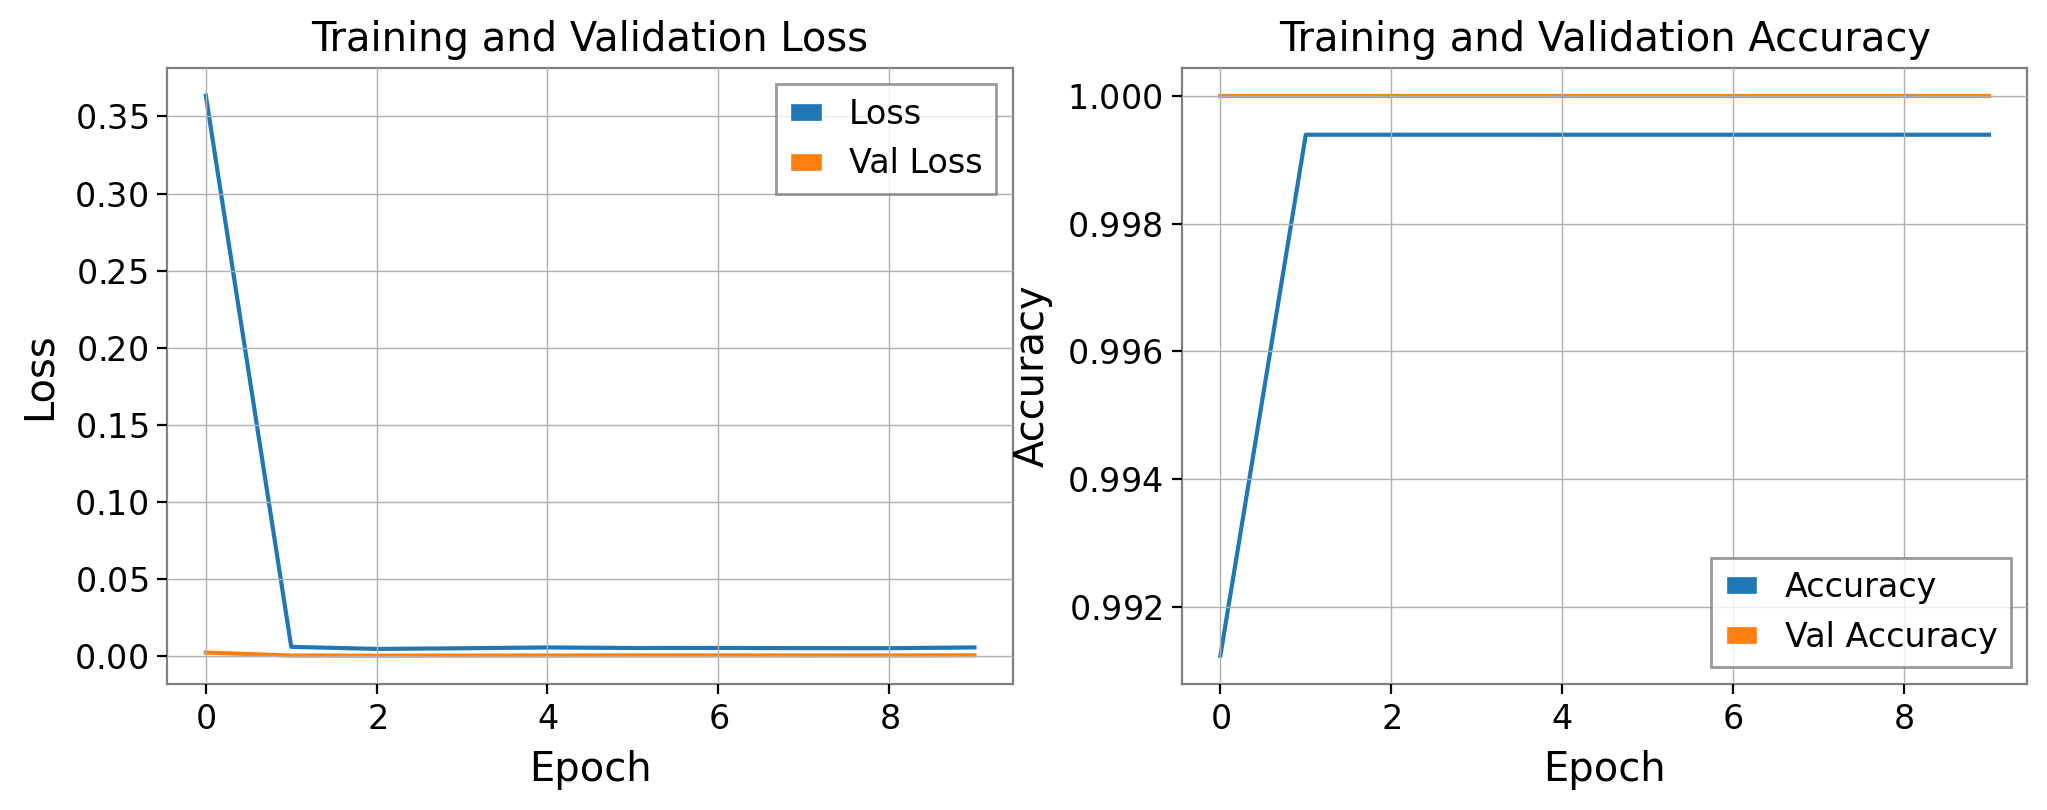

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(segments.shape[1], segments.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train_aug, y_train_aug, epochs=10, batch_size=256, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


## Final Product

In [ ]:
# Save the model (look in the left panel)
model.save('gw_lstm.h5')

# Load the model (for verification)
loaded_model = tf.keras.models.load_model('gw_lstm.h5')

# Verify the loaded model by evaluating it on the test set
loaded_loss, loaded_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Loaded Model Test Loss: {loaded_loss}, Loaded Model Test Accuracy: {loaded_accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1s 54ms/step - loss: 5.5661e-04 - accuracy: 1.0000
Loaded Model Test Loss: 0.0005566077306866646, Loaded Model Test Accuracy: 1.0


# GRU

## Model Training & Evaluation


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 2048, 64)          12864     
                                                                 
 dropout_2 (Dropout)         (None, 2048, 64)          0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37889 (148.00 KB)
Trainable params: 37889 (148.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
39/39

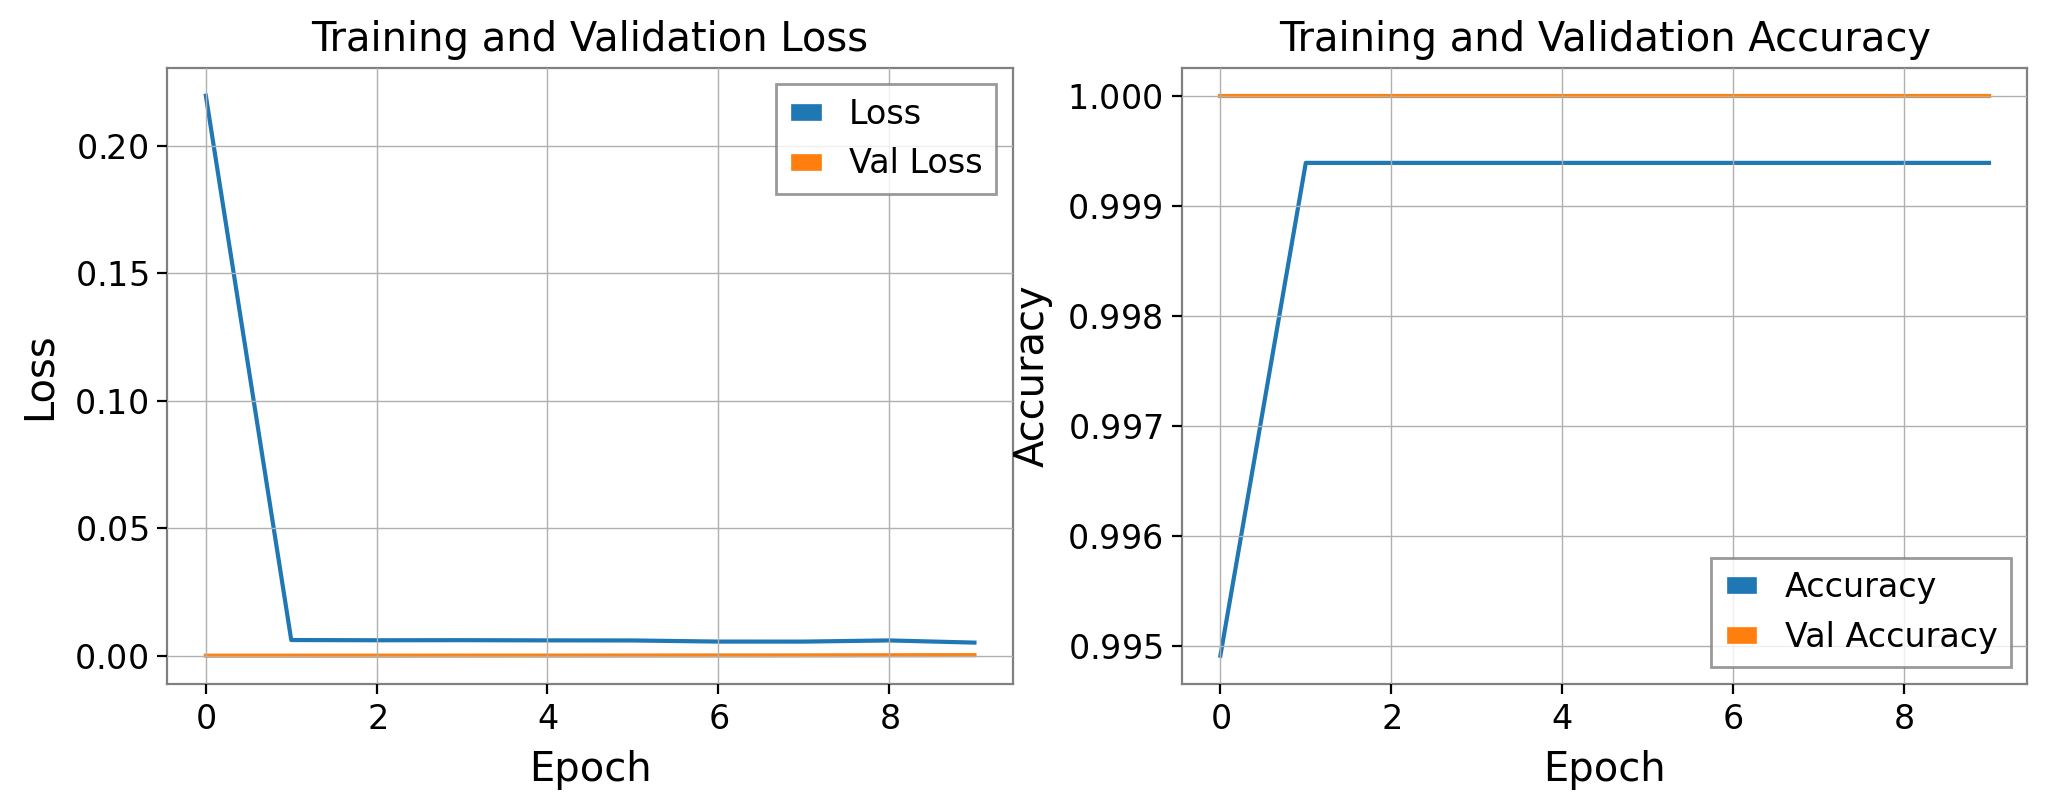

In [ ]:
# Build the GRU model
model = Sequential([
    GRU(64, input_shape=(segments.shape[1], segments.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train_aug, y_train_aug, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


## Final Product

In [ ]:
# Save the model (look in the left panel)
model.save('gw_gru.h5')

# Load the model (for verification)
loaded_model = tf.keras.models.load_model('gw_gru.h5')

# Verify the loaded model by evaluating it on the test set
loaded_loss, loaded_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Loaded Model Test Loss: {loaded_loss}, Loaded Model Test Accuracy: {loaded_accuracy}")


13/13 [==============================] - 2s 67ms/step - loss: 2.2632e-04 - accuracy: 1.0000
Loaded Model Test Loss: 0.00022631992760580033, Loaded Model Test Accuracy: 1.0
